In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator, pickle
from collections import defaultdict
from itertools import cycle, islice
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
ogdf = pd.read_csv('data/watson_eng.csv')
ogdf.head()

,Unnamed: 0,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,ResearchTravelRare,YearsNoChange
0,0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,...,0,8,0,1,6,4,0,5,0,0
1,1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,...,1,10,3,3,10,7,1,7,0,1
2,2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,...,0,7,3,3,0,0,0,0,1,0
3,3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,...,0,8,3,3,8,7,3,0,0,0
4,4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,1,6,3,3,2,2,2,2,1,2


In [3]:
high_df = ogdf[ogdf.MonthlyIncome > 8333]
low_df = ogdf[~ogdf.isin(high_df)]

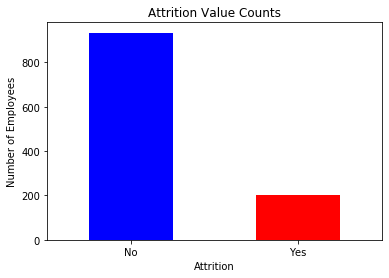

In [14]:
attrition_count = low_df.Attrition.value_counts()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = attrition_count.plot.bar(color=my_colors)
plt.title('Attrition Value Counts')
plt.xlabel('Attrition')
plt.ylabel('Number of Employees')
ax.set_xticklabels(['No', 'Yes'],rotation = 0);

In [12]:
df = high_df.copy(deep=True)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
remove = ['Attrition', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager']
features = df.drop(remove, axis=1)
features_dum = pd.get_dummies(features)
target = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)

X_train, X_test, y_train, y_test = train_test_split(features_dum, target, 
                                                    test_size = 0.2, random_state=99)



In [10]:
# create models
ratio_wei = {1 : 2, 0 : 1}
log = LogisticRegression(C=20, solver='liblinear', max_iter=3000, class_weight=ratio_wei)

In [77]:
kf = KFold(n_splits=5, random_state=99)
model = log
attrib = features_dum

print('F1 Weighted:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='f1_weighted')))
print('Precision:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='precision')))
print('Recall:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='recall')))
print('ROC-AUC:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='roc_auc')))

F1 Weighted: 0.8255583405021468
Precision: 0.4896049231833833
Recall: 0.6947337974845768
ROC-AUC: 0.8543901075663681


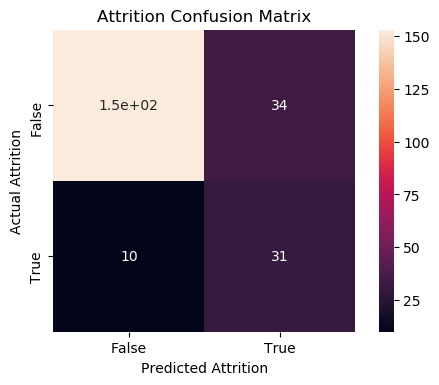

In [78]:
predict = log.fit(X_train,y_train).predict(X_test)
confusion = confusion_matrix(y_test, predict)
plt.figure(dpi=100)
sns.heatmap(confusion[::-1], annot=True, square=True, 
            xticklabels = ['False', 'True'], yticklabels=['True', 'False'])
plt.xlabel('Predicted Attrition')
plt.ylabel('Actual Attrition')
plt.ylim((0,2))
plt.title('Attrition Confusion Matrix');

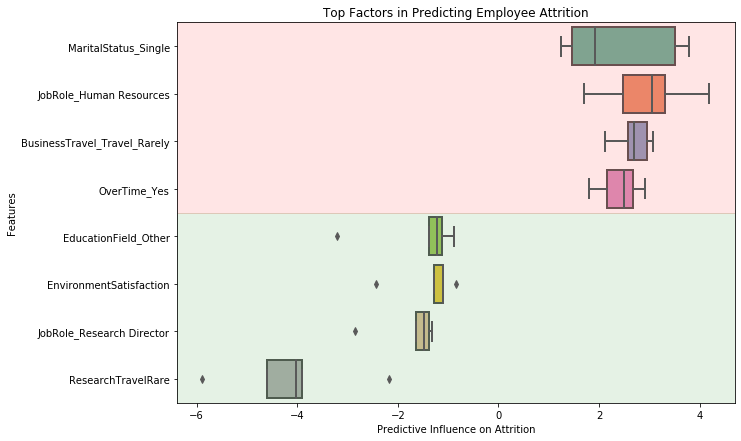

In [13]:
# plot feature coefficient variance
cv_results = cross_validate(log, X_train, y_train, cv=5, return_estimator=True)

feat_coef = []
for model in cv_results['estimator']:
    feat_coef.append(list(zip(X_train.columns, model.coef_[0])))
flat_feat = [item for sublist in feat_coef for item in sublist]

d = defaultdict(list)
for k, v in flat_feat:
    d[k].append(v)
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
x = ([feat[0] for feat in sorted_d[:2]]
     + [feat[0] for feat in sorted_d[4:6]]
    + [feat[0] for feat in sorted_d[-4:]])
y = ([coef[1] for coef in sorted_d[:2]]
    + [coef[1] for coef in sorted_d[4:6]]
    + [coef[1] for coef in sorted_d[-4:]])
with open('feat_coef_high', 'wb') as f:
    pickle.dump(sorted_d, f)

labels = ['Overtime', 'Sales Dept', 'Single', 'HR Role', 'Life Sciences Ed.',
          'Env. Satisfaction', 'Job Involvement', 'Manager Role']
plt.figure(figsize=(10, 7))
ax = sns.boxplot(y,x, linewidth=2, palette='Set2')
# ax.set_xticklabels(labels)
# ax.axhline(3.5, ls='--', c='r')
ax.axhspan(ymin=3.5, ymax=7.5,color='g', alpha=0.1)
ax.axhspan(ymin=-0.5, ymax=3.5,color='r', alpha=0.1)
plt.title('Top Factors in Predicting Employee Attrition')
plt.xlabel('Predictive Influence on Attrition')
plt.ylabel('Features');

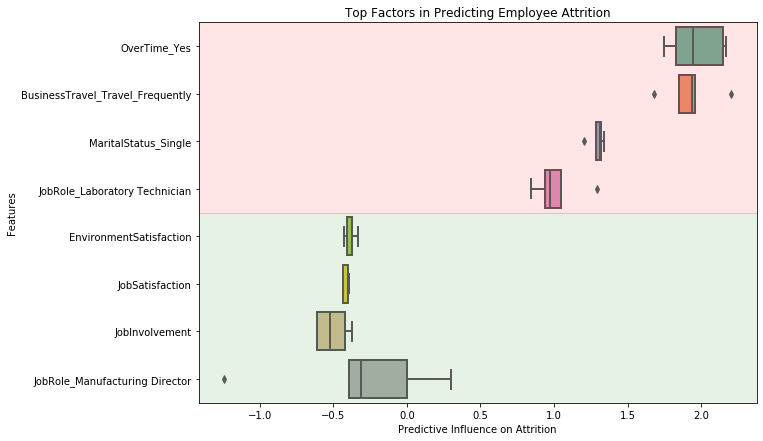

In [11]:
# plot feature coefficient variance
cv_results = cross_validate(log, X_train, y_train, cv=5, return_estimator=True)

feat_coef = []
for model in cv_results['estimator']:
    feat_coef.append(list(zip(X_train.columns, model.coef_[0])))
flat_feat = [item for sublist in feat_coef for item in sublist]

d = defaultdict(list)
for k, v in flat_feat:
    d[k].append(v)
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
x = ([feat[0] for feat in sorted_d[:2]]
     + [feat[0] for feat in sorted_d[4:6]]
    + [feat[0] for feat in sorted_d[-4:]])
y = ([coef[1] for coef in sorted_d[:2]]
    + [coef[1] for coef in sorted_d[4:6]]
    + [coef[1] for coef in sorted_d[-4:]])
with open('feat_coef_low', 'wb') as f:
    pickle.dump(sorted_d, f)

labels = ['Overtime', 'Sales Dept', 'Single', 'HR Role', 'Life Sciences Ed.',
          'Env. Satisfaction', 'Job Involvement', 'Manager Role']
plt.figure(figsize=(10, 7))
ax = sns.boxplot(y,x, linewidth=2, palette='Set2')
# ax.set_xticklabels(labels)
# ax.axhline(3.5, ls='--', c='r')
ax.axhspan(ymin=3.5, ymax=7.5,color='g', alpha=0.1)
ax.axhspan(ymin=-0.5, ymax=3.5,color='r', alpha=0.1)
plt.title('Top Factors in Predicting Employee Attrition')
plt.xlabel('Predictive Influence on Attrition')
plt.ylabel('Features');